# Observations vs Forecast

## All GSOD stations, one runtime

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from scipy.stats import pearsonr
import seaborn as sns
from weatherforce.standardization import standardize_coordinates
import weatherforce.analysis.scoring.contingency as wfcontingency
import weatherforce.analysis.stats as wfstats
import weatherforce.dataviz.graphs.scoring as wfscoring_graphs
import xskillscore as xs

### Import observation GSOD data

Import the gsod data for the filtered stations (in Northern Peru, with enought data).

In [2]:
filtered_stations = pd.read_csv('/home/jovyan/data/share/heloise/ESA-WP11/GSOD/filtered_stations.csv')

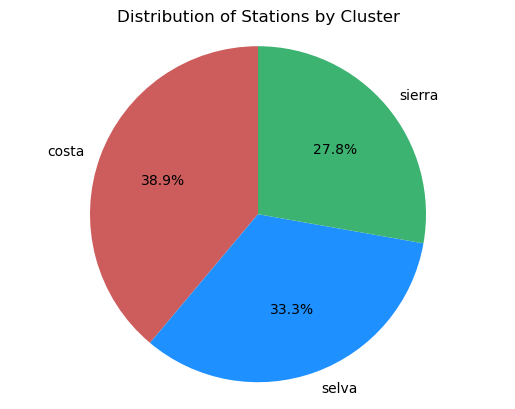

In [3]:
cluster_counts = filtered_stations['cluster'].value_counts()
colors = ['indianred', 'dodgerblue', 'mediumseagreen']

fig, ax = plt.subplots()
ax.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')
plt.title('Distribution of Stations by Cluster')
plt.show()

#fig.savefig('distribution_stations_by_cluster.png')

### Functions

In [4]:
newpath = f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/figures_gsod_c3s_downscaled' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [1]:
def get_c3s_data_downscaled(par: str = 'pr', year: int = 1993, month: int = 1):

    '''
    Get C3S seasonal forecast (ECMWF SEAS5) for a specific month and year.

    Args:
        par: the parameter name, by default 'tp'
        year: desired year, by default '1993'
        month: desired month, by default 1 (january)

    Returns:
        C3S data for a specific month and year
    '''
    filepath = f'/home/jovyan/data/share/Martin/ESA/WP11/c3s_seasonal/downscaled/{par}/peru_north/1km/method_002/{year}/{month:02d}'
    filename = f'tp_c3s_downscaled_peru_north_{year}_{month:02d}.nc'
        
    ds = xr.open_dataset(os.path.join(filepath, filename))
    ds[par] = xr.where(ds[par] < 0, 0, ds[par])
        
    return ds

In [6]:
def compute_metrics(predicted, reference):
    """
    Compute the specified metric between the predicted and reference fields.

    Args:
        - predicted (array-like):predicted field.
        - reference (array-like): reference field.
        
    Returns:
        - result: float, computed metric result, normalized bias, mae, rmse, pearson score, skill score
    """
    
    # Calculate the normalized bias
    bias = predicted - reference
    min_val = np.min(bias)
    max_val = np.max(bias)
    normalized_bias = (bias - min_val) / (max_val - min_val)
    
    # Calculate MAE
    mae = mean_absolute_error(reference, predicted)

    # Calculate RMSE
    mse = mean_squared_error(reference, predicted)
    rmse = math.sqrt(mse)

    # Calculate Pearson's correlation
    corr, _ = pearsonr(reference, predicted)

    # Calculate Skill Score
    rmse2 = rmse ** 2 # root-mean-square error 
    sdev2 = np.std(reference, ddof=1) ** 2 # standard deviation
    if sdev2 != 0:
        skill_score = 1 - rmse2 / sdev2 # SS = 1 - RMSE^2/SDEV^2
    else:
        skill_score = np.nan
    
    #brier_score = xs.brier_score(reference, predicted)

    return normalized_bias, mae, rmse, corr, skill_score#, brier_score


In [7]:
def plot_station_data(time, predicted, reference):
    """
    Plot the station data including forecasted and observed precipitation along with the absolute bias.

    Args:
        - time (array-like): Time axis values for the plot.
        - predicted (array-like): Forecasted precipitation values.
        - reference (array-like): Observed precipitation values.

    Returns:
        None (displays the plot).

    """
    abs_bias = np.abs(predicted - reference)

    fig = plt.figure()
    plt.plot(time, predicted, label='forecast', color='b')
    plt.plot(time, reference, label='observation', color='g')
    plt.plot(time, abs_bias, label='absolute bias', color='r', ls=':')
    plt.xlabel('Month')
    plt.ylabel('tp (mm)')
    plt.title(f'Cumulative monthly mean precipitation \nRuntime {time_min:%Y-%m}')
    plt.legend()
    plt.show()

In [8]:
def plot_model_error(predicted, reference, date):
    """
    Plot the error between model predictions and observations with model overestimation and underestimation.

    Args:
        predicted (array-like): Model predicted values.
        reference (array-like): Observed reference values.
        date (array-like): Dates or timestamps corresponding to the predicted and reference values.

    Returns:
        None (displays the error plot).
    """
    error = predicted - reference
    zeros = [0] * len(date)
    
    plt.figure()
    overestimate = plt.fill_between(date, error, zeros, where=(error >= zeros),
                                    color='#ff7051', alpha=0.6, interpolate=True)
    underestimate = plt.fill_between(date, error, zeros, where=(zeros >= error),
                                     color='#5797ff', alpha=0.6, interpolate=True)
    
    max_error = max(abs(error)) + 2
    min_error = min(abs(error)) - 2
    plt.ylim(top=max_error, bottom=min_error)
    plt.xlabel('Time (month)')
    plt.ylabel('Error (mm)')
    plt.legend([overestimate, underestimate],
               ["Model that overestimates precipitation", "Model that underestimates precipitation"],
               loc="best", prop={'size': 10}, title_fontsize=10)
    plt.title("Model error")
    plt.grid(True)
    plt.show()

In [9]:
def plot_bias(metrics_df):
    """
    Plot the biases for all stations in the same plot.

    Args:
        - metrics_df (DataFrame): DataFrame containing the metrics for each station, including the normalized bias.

    Returns:
        None (displays the plot).

    """
    fig_bias, ax_bias = plt.subplots()
    cluster_colors = {'costa': 'indianred', 'sierra': 'dodgerblue', 'selva': 'mediumseagreen'}

    for index, row in metrics_df.iterrows():
        station_name = row['name']
        cluster = row['cluster']
        color_clust = cluster_colors.get(cluster, 'gray')
        ax_bias.plot(time, metrics_df.norm_bias[index], color=color_clust)

    legend_elements = [
        plt.Line2D([0], [0], color='indianred', lw=2, label='Cluster Costa'),
        plt.Line2D([0], [0], color='dodgerblue', lw=2, label='Cluster Sierra'),
        plt.Line2D([0], [0], color='mediumseagreen', lw=2, label='Cluster Selva')
    ]
    ax_bias.legend(handles=legend_elements)

    ax_bias.set_xlabel('Month')
    ax_bias.set_ylabel('Normalized bias')
    ax_bias.set_title(f'Observation-Forecast biases \nRuntime {time_min:%Y-%m}')
    plt.show()
    fig_bias.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/figures_gsod_c3s_downscaled/tp_bias_runtime_{time_min:%Y_%m}_method_{grid_method}.png')

In [10]:
def evaluate_forecast(obs, model, percentage: float = 0.5):
    '''
    Evaluate the forecast performance of a model by comparing it to the observed values. 
    It checks whether the model's predictions fall within a specified percentage range 
    around the observed values for each time step.

    Args:
        obs (panda series): observed reference values.
        model (xarray): model prediction values.
        percentage (float): percentage range around the observed values within which the 
        model's predictions are considered accurate, by default 0.5 (50%)

    Returns:
        evaluate_tab: list containing the evaluation results for each time step (good or wrong forecast)
    '''
    
    evaluate_tab = []
    
    for t in range (model.sizes['time']):
        
        tp_obs = obs.values[t]
        tp_pred = model.isel(time=t)
        
        delta = tp_obs*percentage
        
        if (tp_obs == 0):
            if (tp_pred >5):
                evaluate_tab.append('wrong forecast - should be zero')
            else : 
                evaluate_tab.append('good forecast - no rain')
        
        elif ((tp_obs <= 5) & (tp_pred <=5)):
            evaluate_tab.append('good forecast - no rain')
        
        elif (((tp_obs - delta) < tp_pred) & (tp_pred < (tp_obs + delta))):
            if (tp_pred<= tp_obs):
                evaluate_tab.append('good forecast - underestimate')
            else:
                 evaluate_tab.append('good forecast - overestimate')
            
        else:
            if (tp_pred<tp_obs):
                 evaluate_tab.append('wrong forecast - below')
            else:
                 evaluate_tab.append('wrong forecast - above')
    
    return evaluate_tab

In [11]:
def plot_contingency(truth, prediction, digit_labels, name_labels):    
    """       
    Plot and return the contingency table based on the digits of observation truth and predicted labels.

    Args:
        truth (array-like): Observation truth labels.
        prediction (array-like): Predicted labels.
        digit_labels (array-like): Digit labels used in the confusion matrix.
        name_labels (array-like): Name labels corresponding to the digit labels.

    Returns:
        array-like: The confusion matrix.

    """    

    # Calculate confusion matrix
    cm = confusion_matrix(truth, prediction, labels=digit_labels, normalize=None)
    
    plt.figure()
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cbar=None, cmap="Blues", linewidths=1, linecolor="w")
    
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Observation')
    ax.set_title('Contingency table')
    ax.xaxis.set_ticklabels(name_labels)
    ax.yaxis.set_ticklabels(name_labels)

    return cm

### Apply "deterministic" approach

Use the mean members of the forecast

Current runtime _____________________________________________________________ 

Runtime: 1995-08, forecast until: 1996-01.
_____________________________________________________________________________ 


Station PEDRO CANGA, cluster costa __________________________________________
Latitude: -3.553°, Longitude: -80.381° 

Forecast 
Latitude: -3.55416666666666°, Longitude: -80.37916666666666° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - below', 'good forecast - no rain', 'good forecast - no rain', 'wrong forecast - below', 'good forecast - underestimate', 'wrong forecast - above']



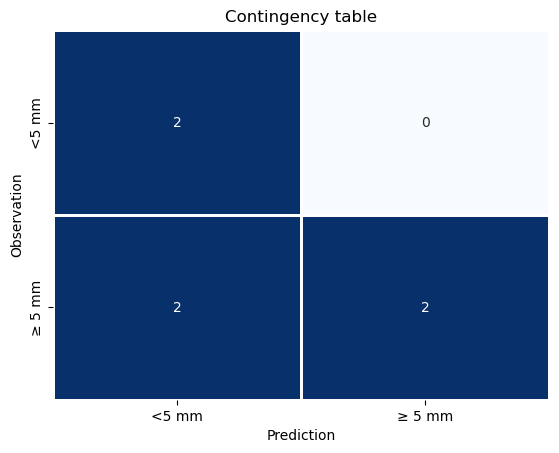

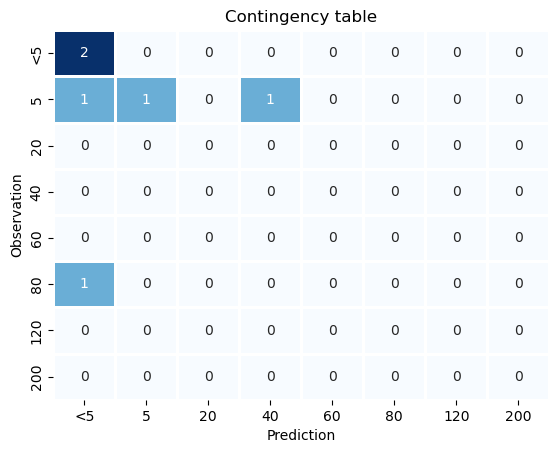

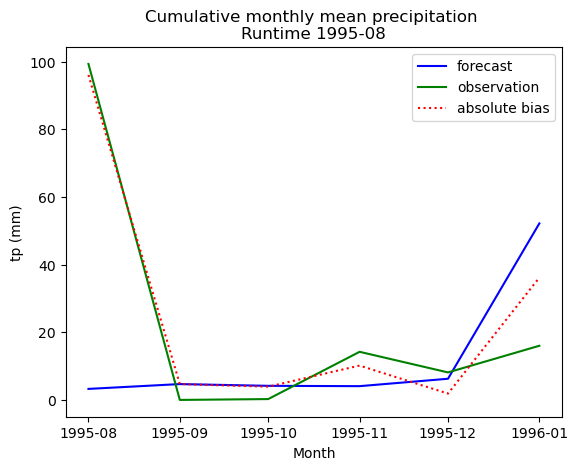

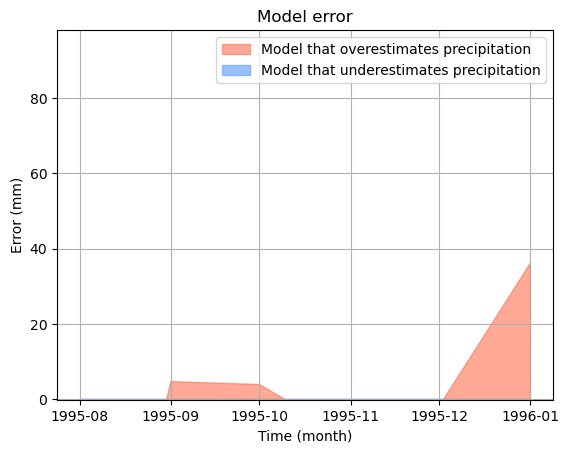


Station CAPITAN MONTES, cluster costa __________________________________________
Latitude: -4.577°, Longitude: -81.254° 

Forecast 
Latitude: -4.579166666666666°, Longitude: -81.25416666666666° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain']



/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


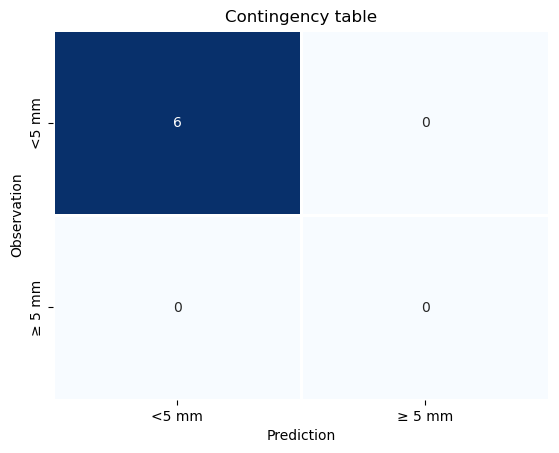

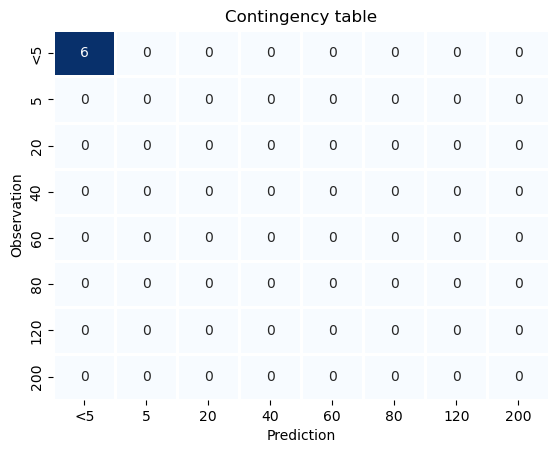

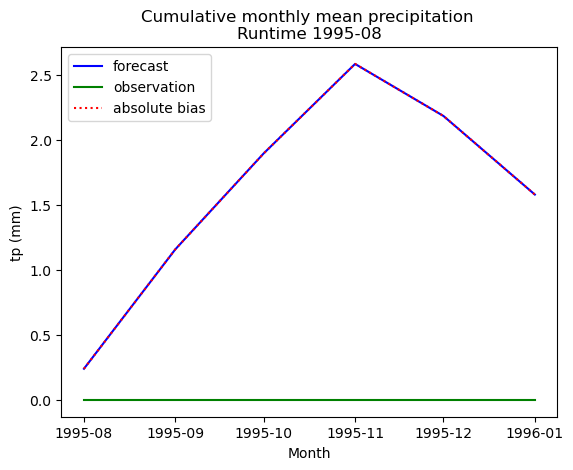

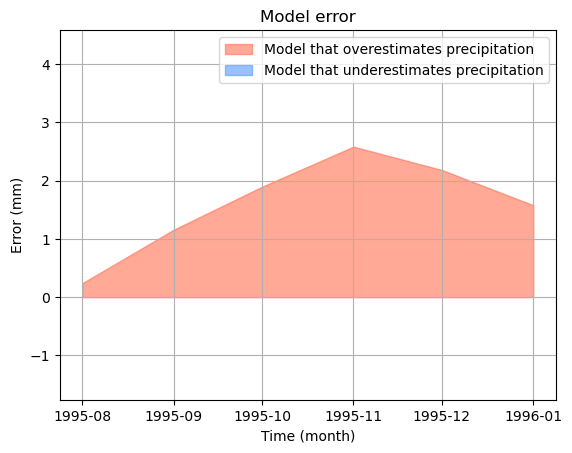


Station CAPITAN FAP GUILLERMO CONCHA IBERICO, cluster costa __________________________________________
Latitude: -5.206°, Longitude: -80.616° 

Forecast 
Latitude: -5.204166666666666°, Longitude: -80.6125° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'wrong forecast - should be zero', 'wrong forecast - above', 'wrong forecast - above']



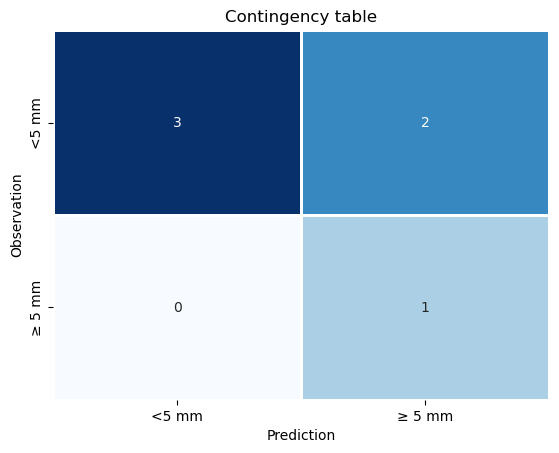

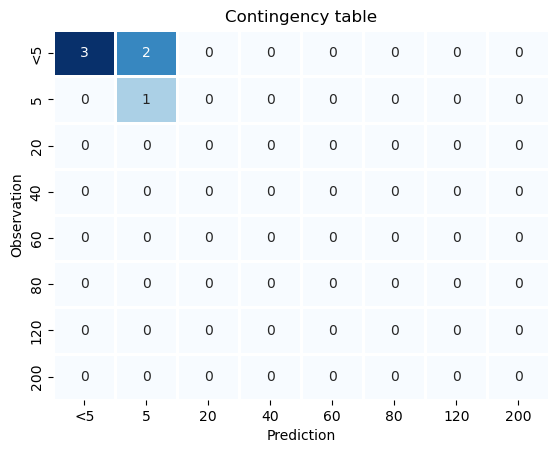

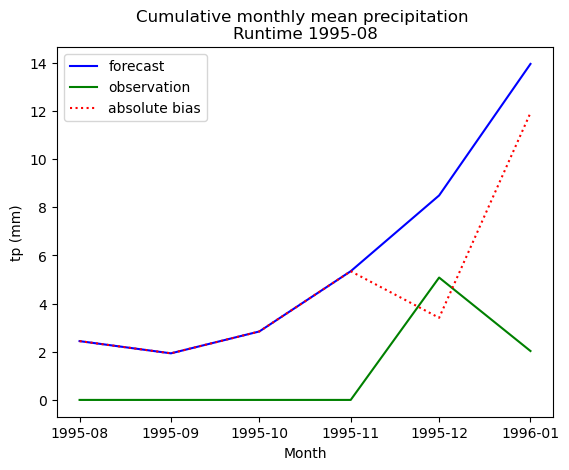

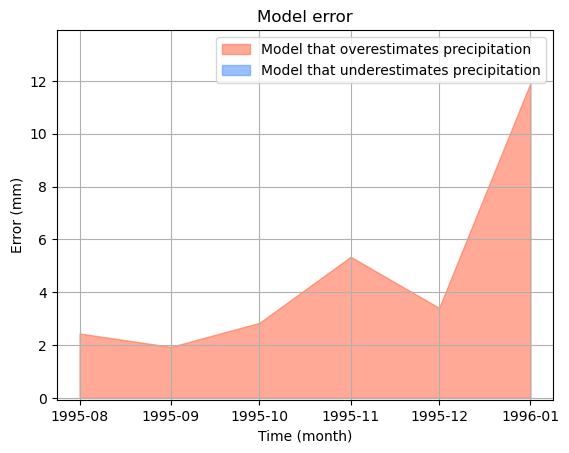


Station MOISES BENZAQUEN RENGIFO, cluster selva __________________________________________
Latitude: -5.894°, Longitude: -76.118° 

Forecast 
Latitude: -5.895833333333329°, Longitude: -76.12083333333334° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'good forecast - overestimate', 'wrong forecast - above', 'good forecast - overestimate', 'good forecast - overestimate', 'good forecast - underestimate']



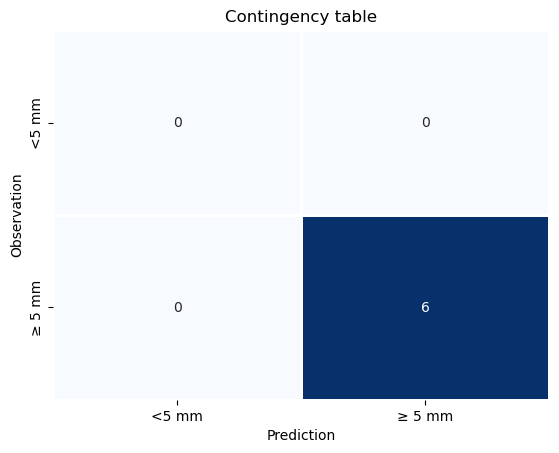

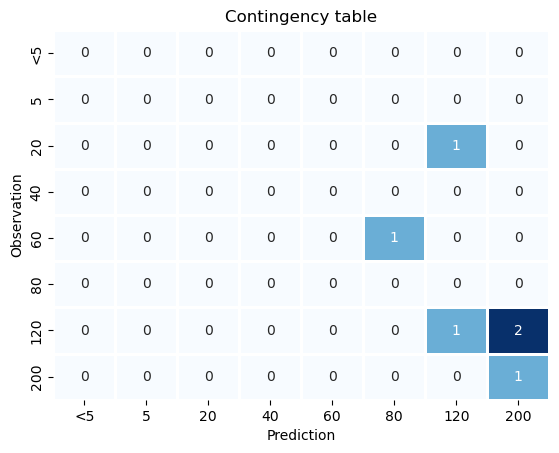

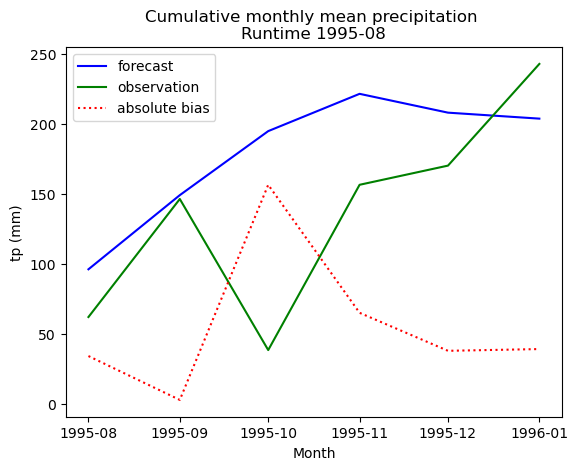

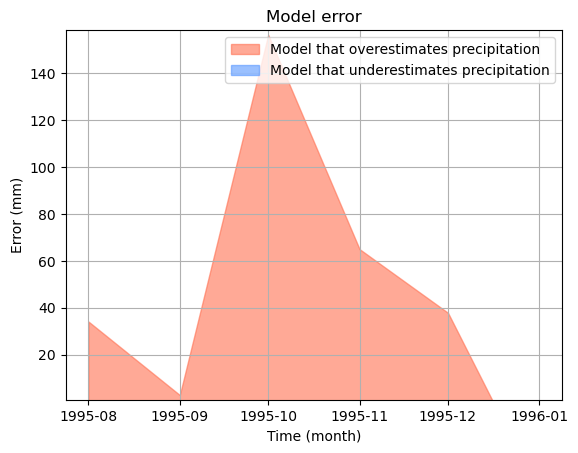


Station JUAN SIMONS VELA, cluster selva __________________________________________
Latitude: -6.068°, Longitude: -77.16° 

Forecast 
Latitude: -6.070833333333326°, Longitude: -77.16250000000001° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - underestimate', 'good forecast - underestimate']



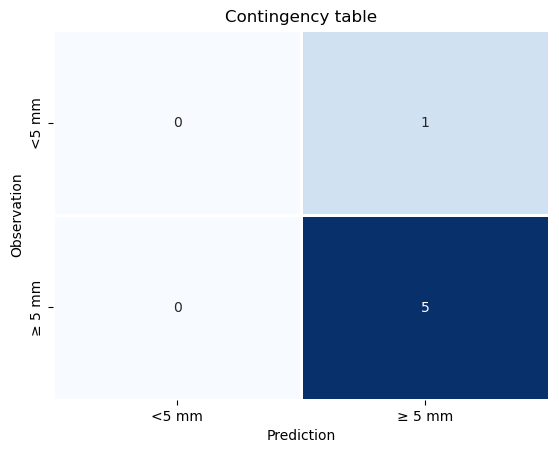

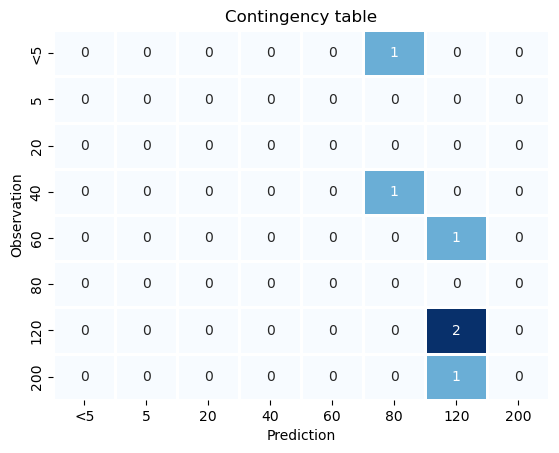

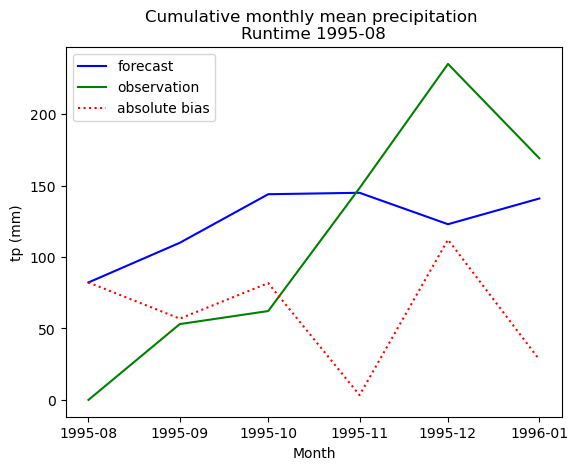

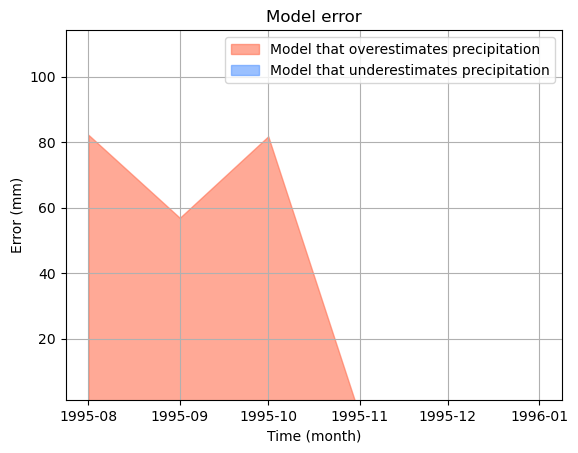


Station CHACHAPOYAS, cluster sierra __________________________________________
Latitude: -6.202°, Longitude: -77.856° 

Forecast 
Latitude: -6.204166666666666°, Longitude: -77.85416666666667° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above']



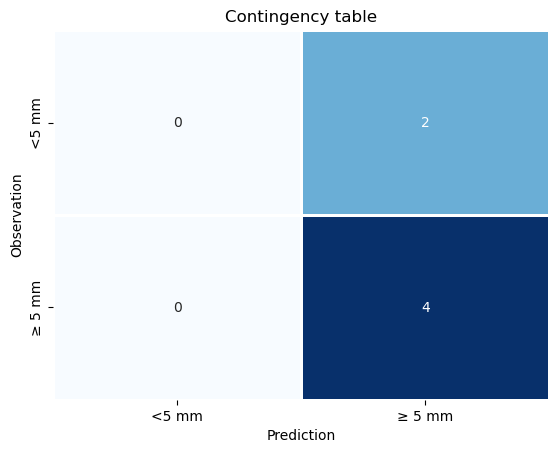

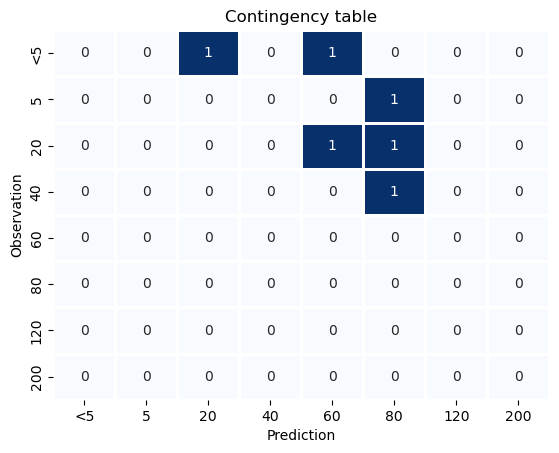

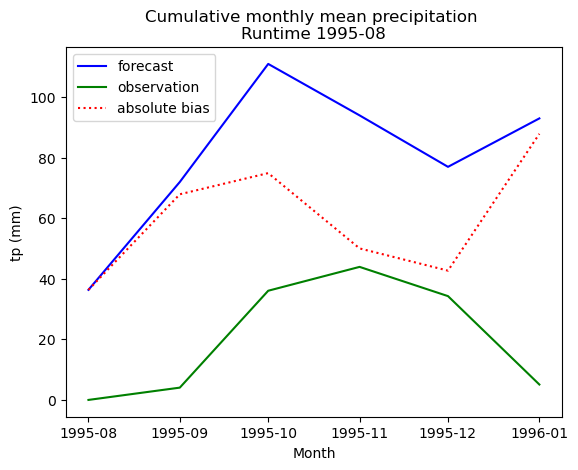

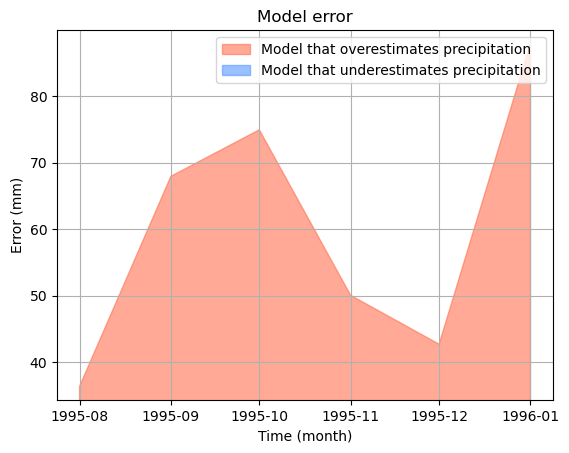


Station CAPT JOSE A  QUINONES GONZALES INTL, cluster costa __________________________________________
Latitude: -6.787°, Longitude: -79.828° 

Forecast 
Latitude: -6.787499999999994°, Longitude: -79.82916666666667° 

Accuracy for the contingency table rain/no rain: 66.67 %

Evaluation of the model for each month: 
['good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'wrong forecast - should be zero', 'wrong forecast - should be zero']



/srv/conda/envs/notebook/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


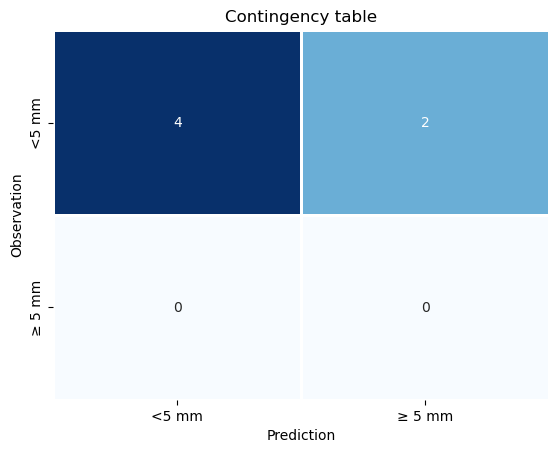

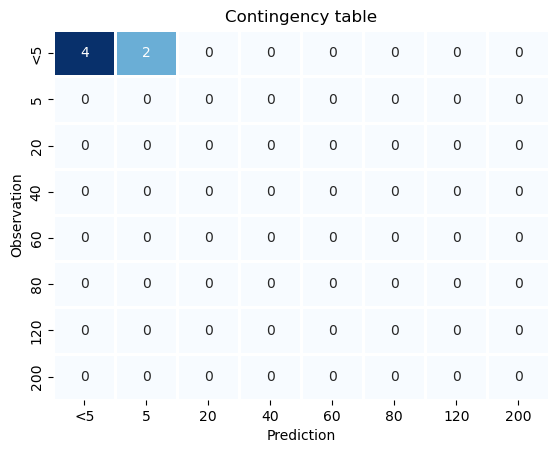

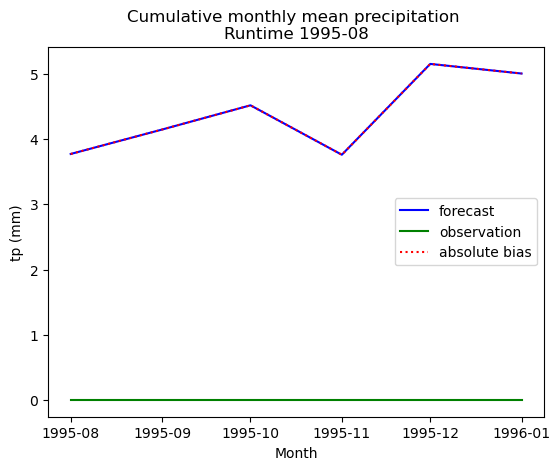

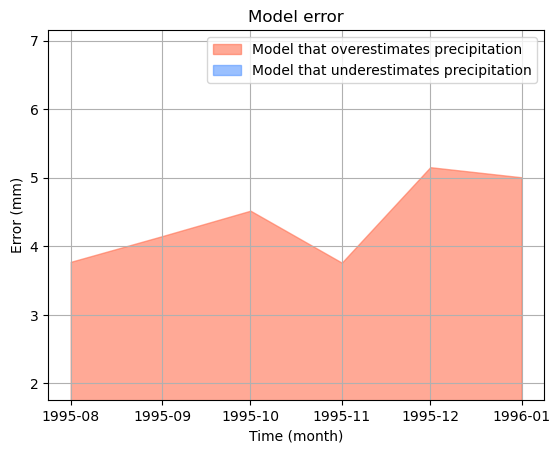


Station CADETE GUILLERMO DEL CASTILLO PAREDES, cluster selva __________________________________________
Latitude: -6.509°, Longitude: -76.373° 

Forecast 
Latitude: -6.512500000000003°, Longitude: -76.37083333333334° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'good forecast - overestimate', 'wrong forecast - above', 'good forecast - overestimate', 'wrong forecast - above', 'good forecast - underestimate']



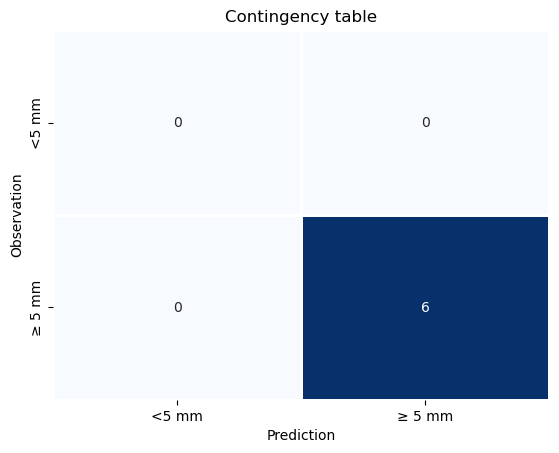

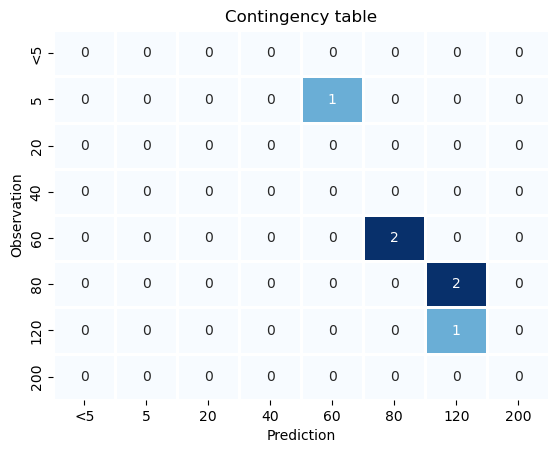

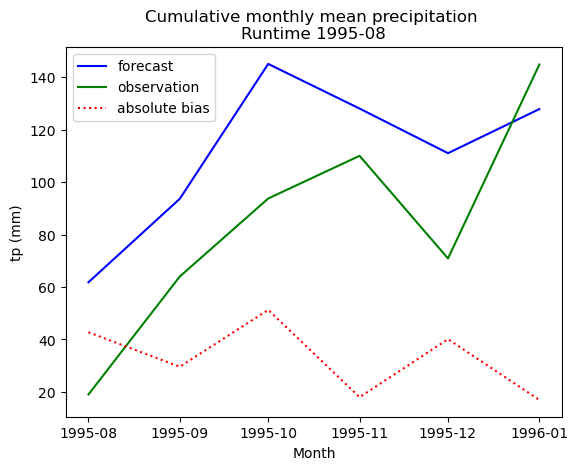

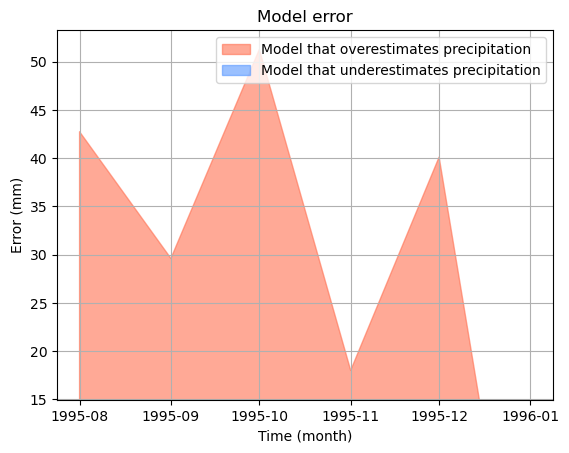


Station GEN FAP ARMANDO REVOREDO IGLESIAS, cluster sierra __________________________________________
Latitude: -7.139°, Longitude: -78.489° 

Forecast 
Latitude: -7.137500000000003°, Longitude: -78.4875° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['good forecast - overestimate', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - underestimate', 'good forecast - overestimate']



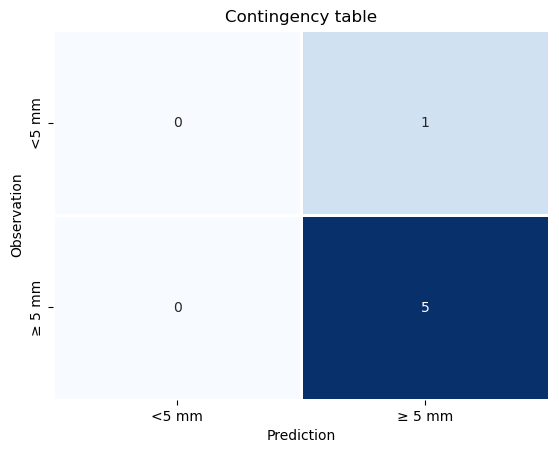

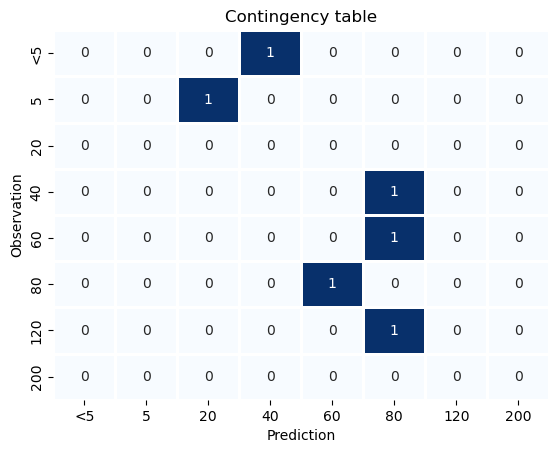

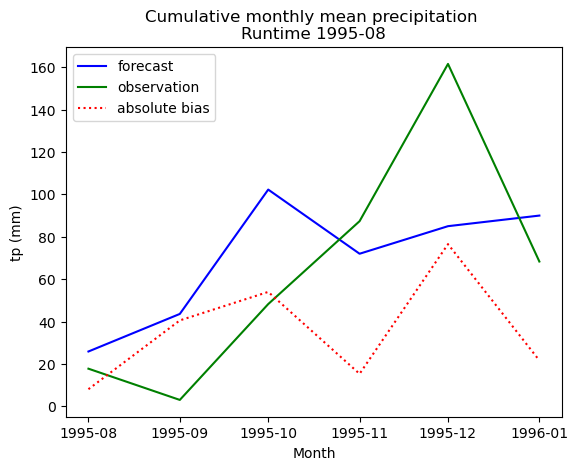

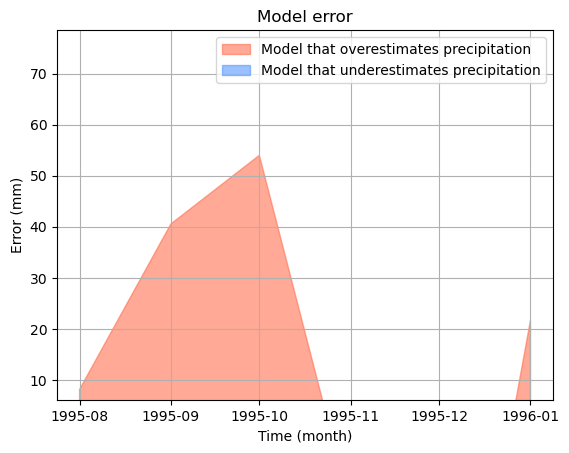


Station JUANJUI, cluster selva __________________________________________
Latitude: -7.169°, Longitude: -76.729° 

Forecast 
Latitude: -7.170833333333334°, Longitude: -76.72916666666667° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - underestimate', 'good forecast - underestimate']



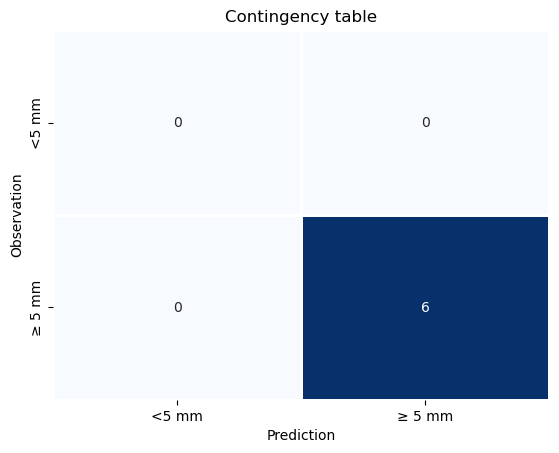

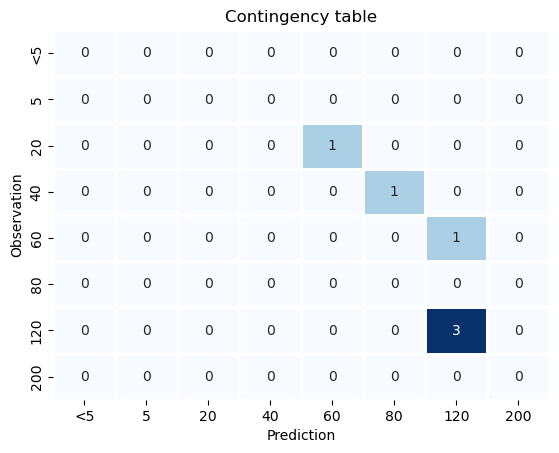

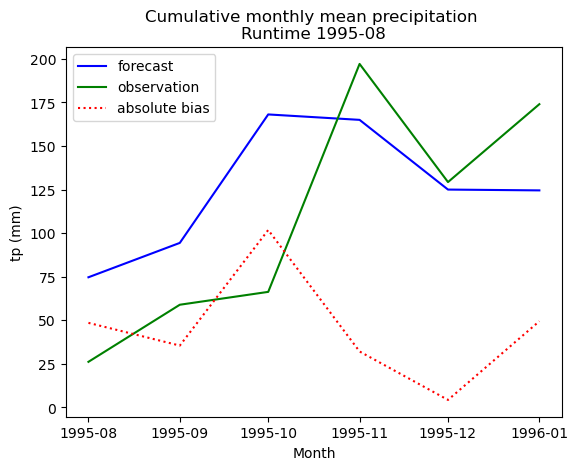

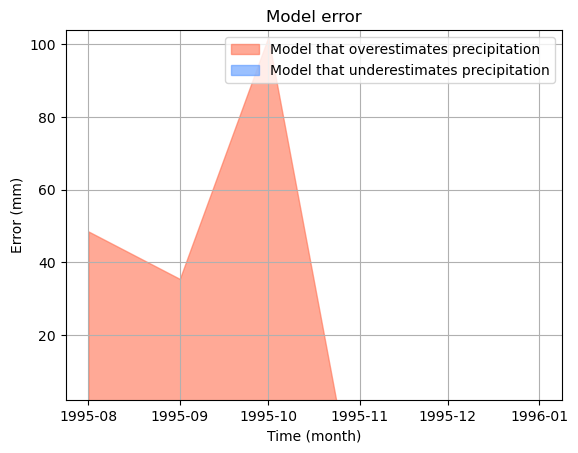


Station CAPITAN CARLOS MARTINEZ DE PINILLOS, cluster costa __________________________________________
Latitude: -8.081°, Longitude: -79.109° 

Forecast 
Latitude: -8.079166666666666°, Longitude: -79.1125° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain']



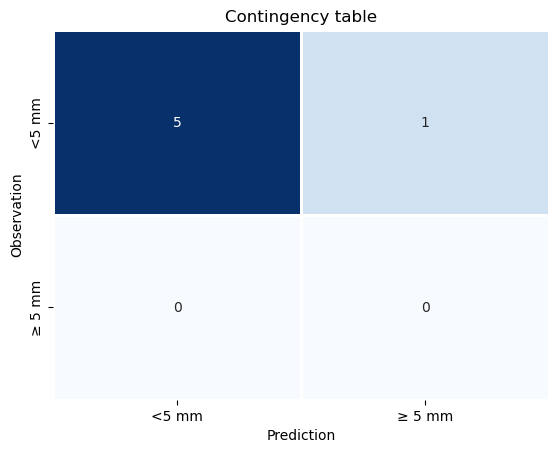

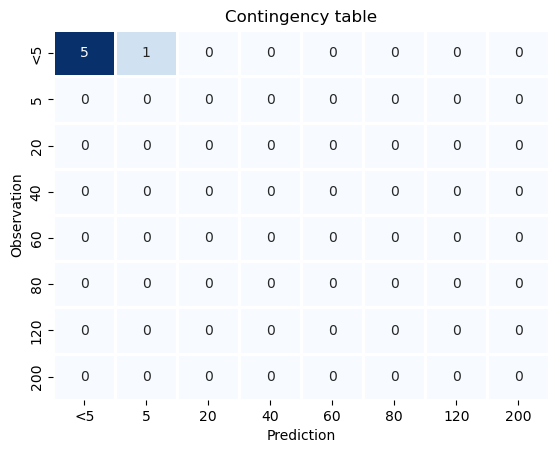

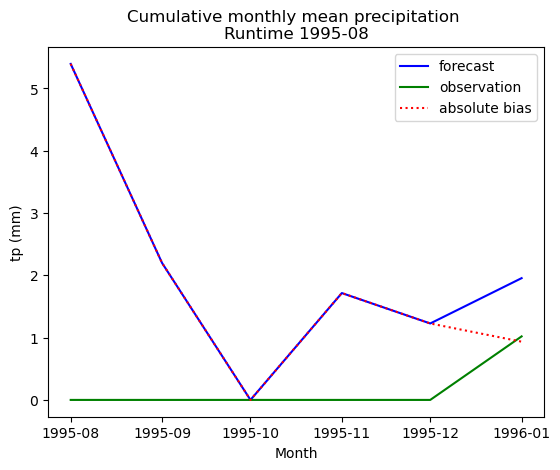

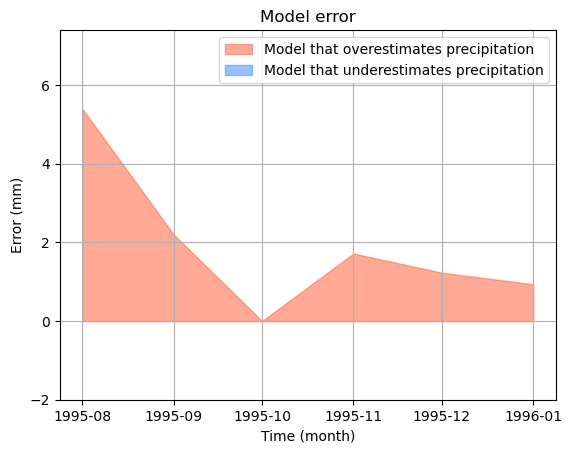


Station CAP FAP DAVID ABENZUR RENGIFO INTL, cluster selva __________________________________________
Latitude: -8.378°, Longitude: -74.574° 

Forecast 
Latitude: -8.379166666666663°, Longitude: -74.57083333333334° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - below', 'wrong forecast - above', 'good forecast - underestimate', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - underestimate']



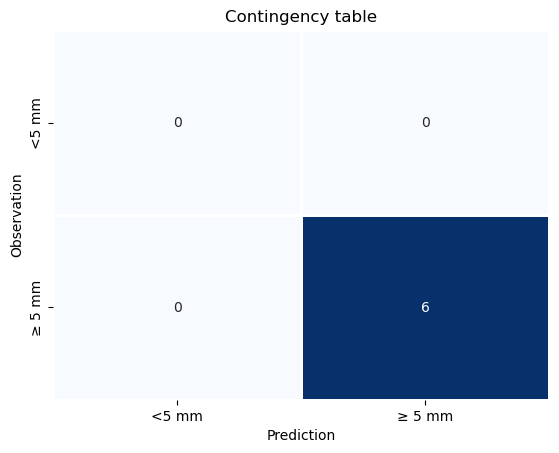

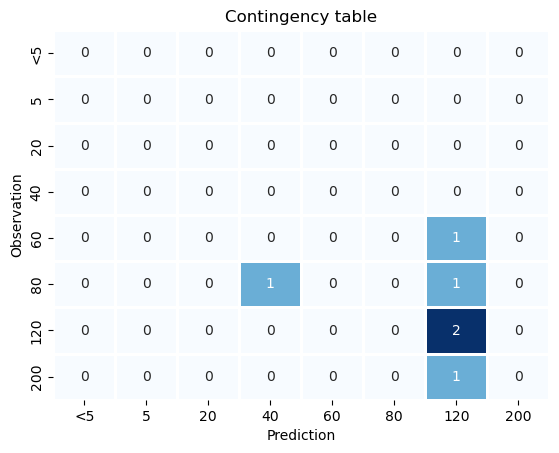

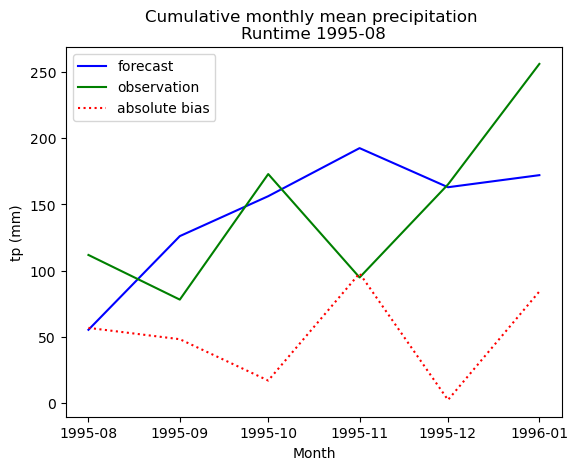

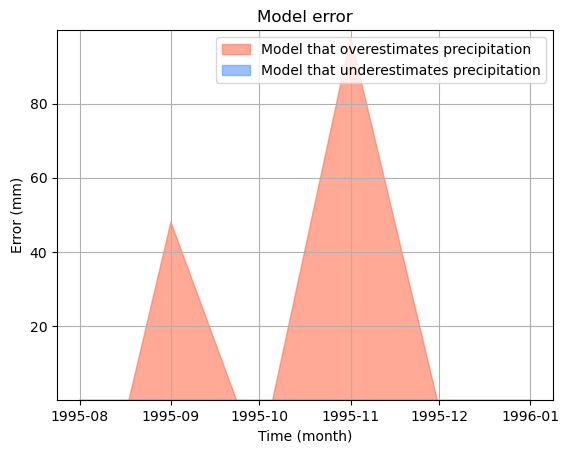


Station TENIENTE JAIME A DE MONTREUIL MORALES, cluster costa __________________________________________
Latitude: -9.15°, Longitude: -78.524° 

Forecast 
Latitude: -9.154166666666669°, Longitude: -78.52083333333333° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain']



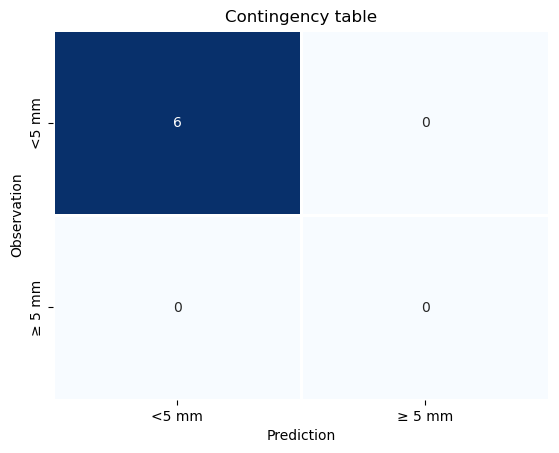

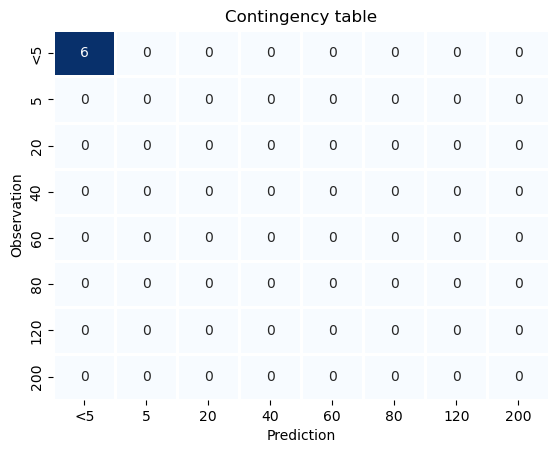

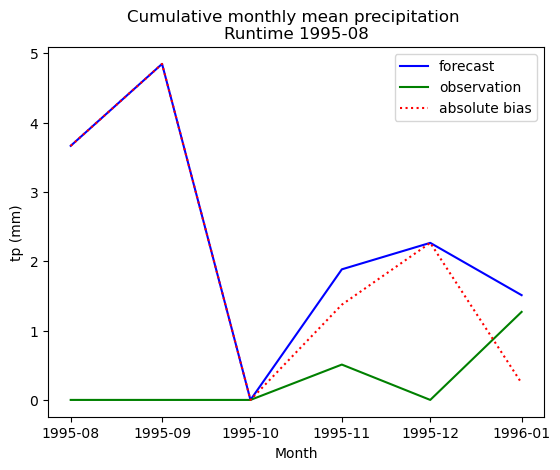

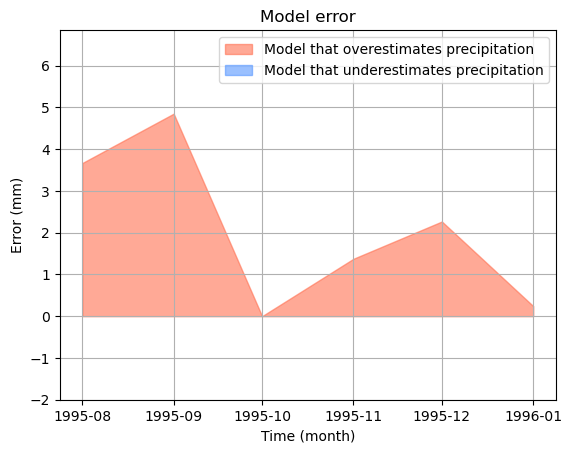


Station TINGO MARIA, cluster selva __________________________________________
Latitude: -9.133°, Longitude: -75.95° 

Forecast 
Latitude: -9.129166666666663°, Longitude: -75.94583333333334° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['wrong forecast - above', 'good forecast - overestimate', 'good forecast - overestimate', 'good forecast - overestimate', 'wrong forecast - above', 'good forecast - overestimate']



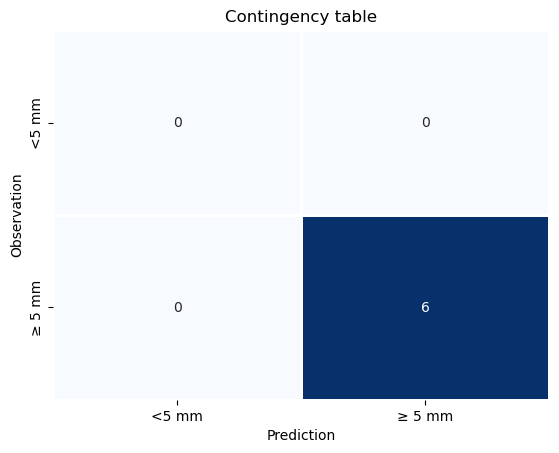

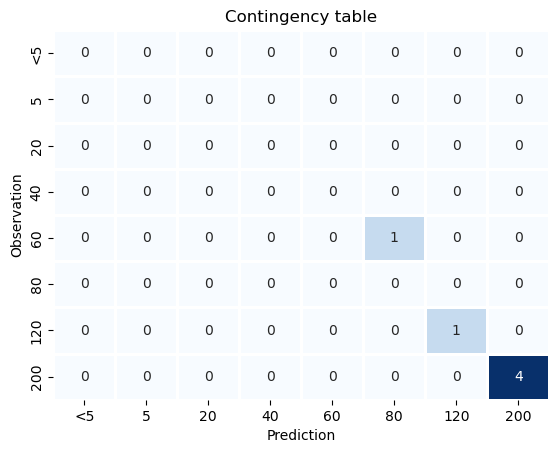

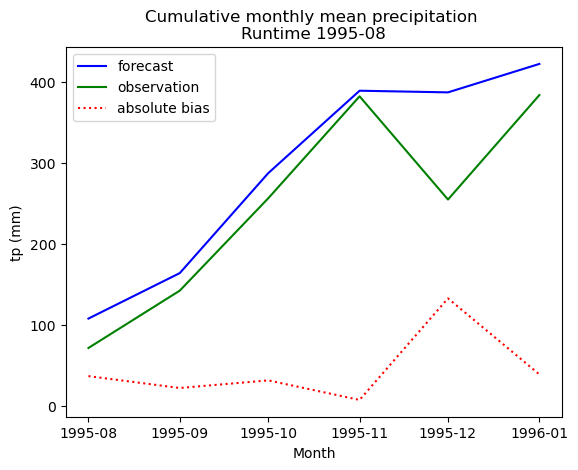

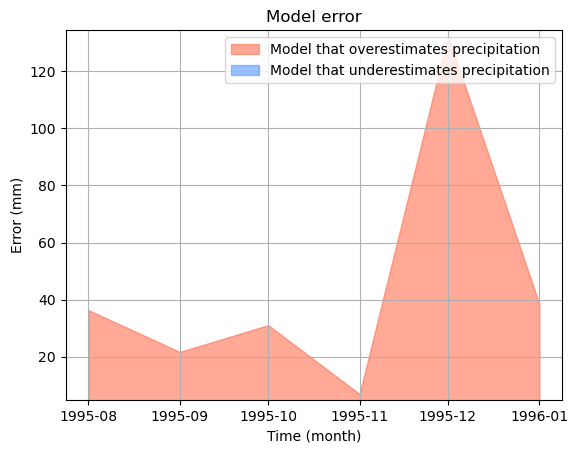


Station COMANDANTE FAP GERMAN ARIAS GRAZIANI, cluster sierra __________________________________________
Latitude: -9.347°, Longitude: -77.598° 

Forecast 
Latitude: -9.345833333333331°, Longitude: -77.59583333333333° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'wrong forecast - above', 'good forecast - overestimate', 'good forecast - overestimate', 'good forecast - underestimate', 'good forecast - overestimate']



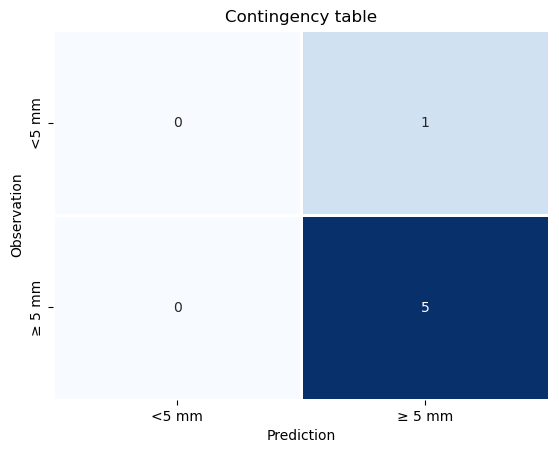

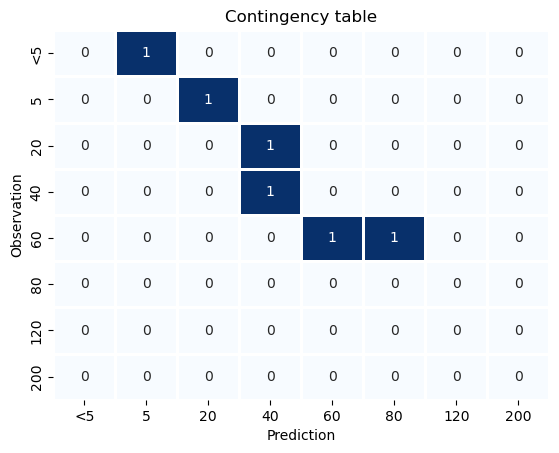

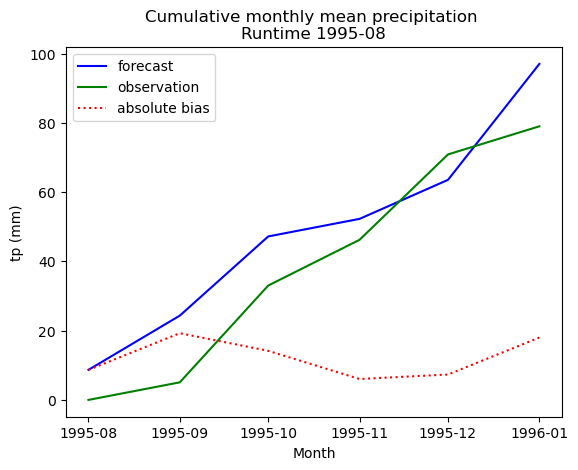

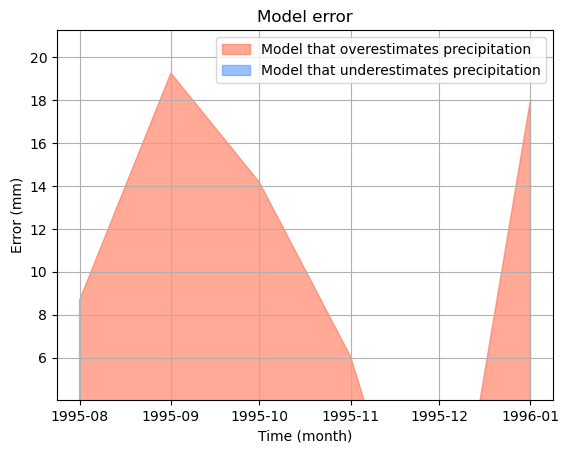


Station ALFEREZ FAP D F FERNANDINI, cluster sierra __________________________________________
Latitude: -9.879°, Longitude: -76.205° 

Forecast 
Latitude: -9.879166666666663°, Longitude: -76.20416666666667° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'wrong forecast - above', 'wrong forecast - above', 'good forecast - underestimate', 'good forecast - overestimate', 'good forecast - overestimate']



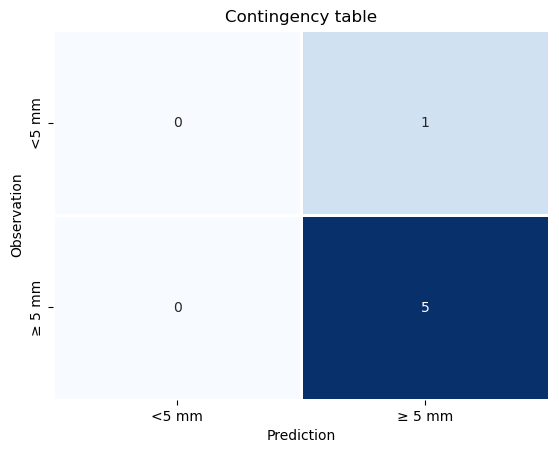

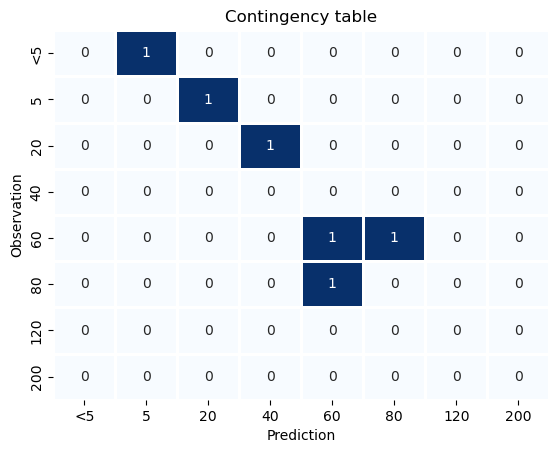

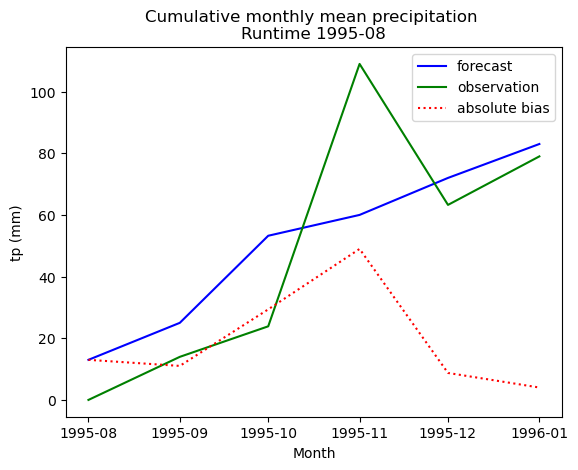

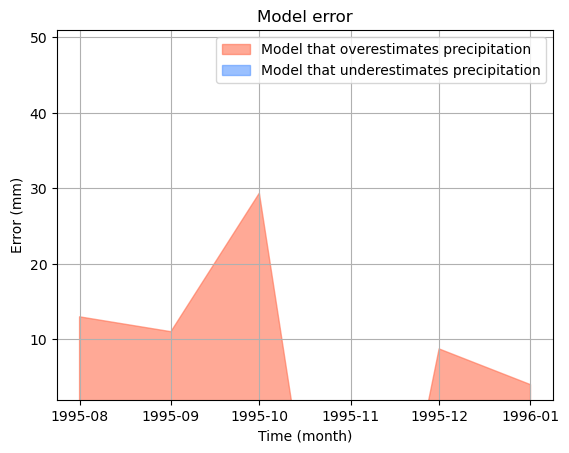


Station JORGE CHAVEZ INTL, cluster costa __________________________________________
Latitude: -12.022°, Longitude: -77.114° 

Forecast 
Latitude: -12.020833333333329°, Longitude: -77.1125° 

Accuracy for the contingency table rain/no rain: 100.00 %

Evaluation of the model for each month: 
['good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain', 'good forecast - no rain']



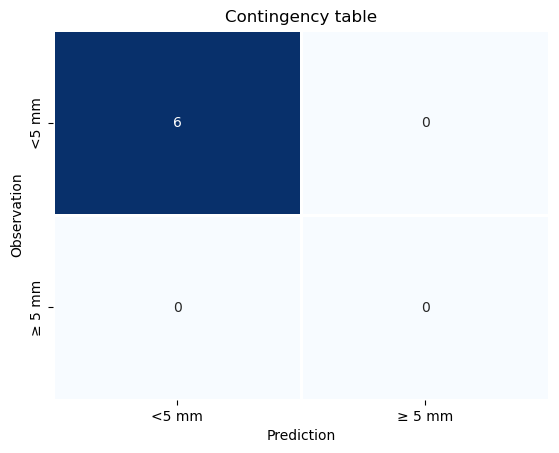

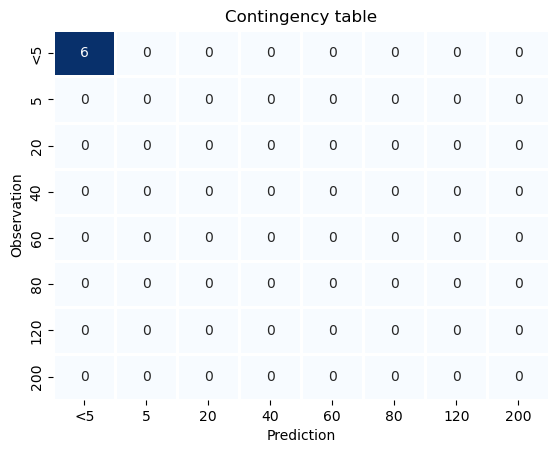

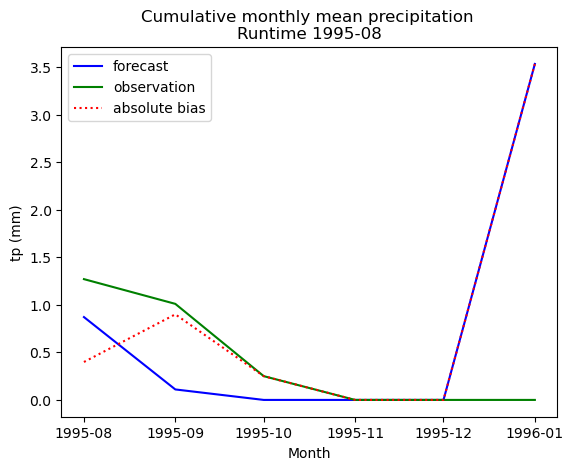

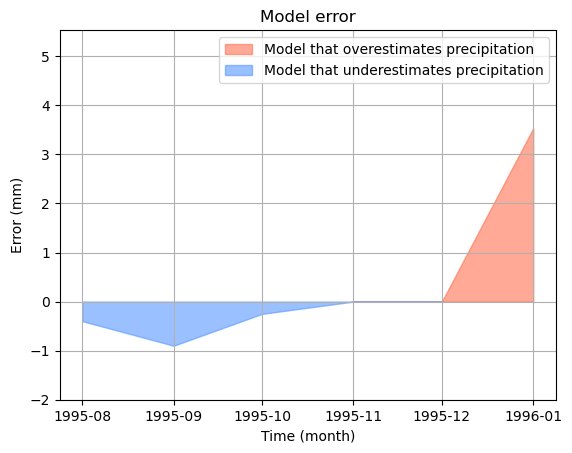


Station CORONEL FAP ALFREDO MENDIVIL DUARTE, cluster sierra __________________________________________
Latitude: -13.155°, Longitude: -74.204° 

Forecast 
Latitude: -13.154166666666669°, Longitude: -74.20416666666667° 

Accuracy for the contingency table rain/no rain: 83.33 %

Evaluation of the model for each month: 
['wrong forecast - should be zero', 'wrong forecast - above', 'good forecast - underestimate', 'wrong forecast - below', 'good forecast - overestimate', 'good forecast - underestimate']



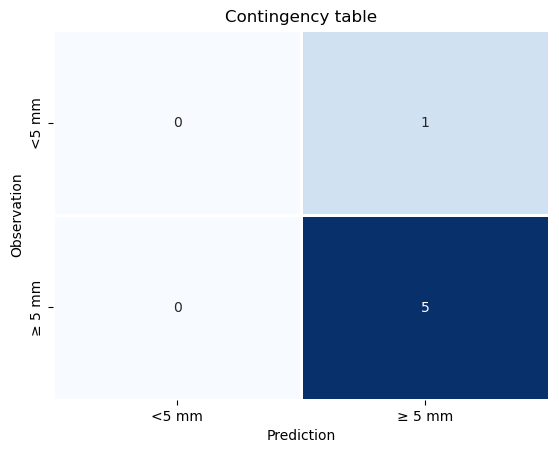

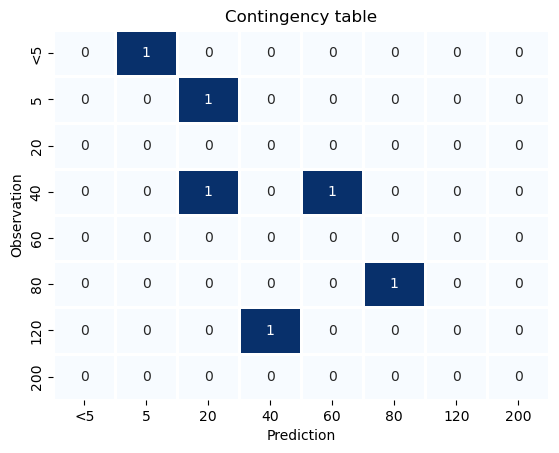

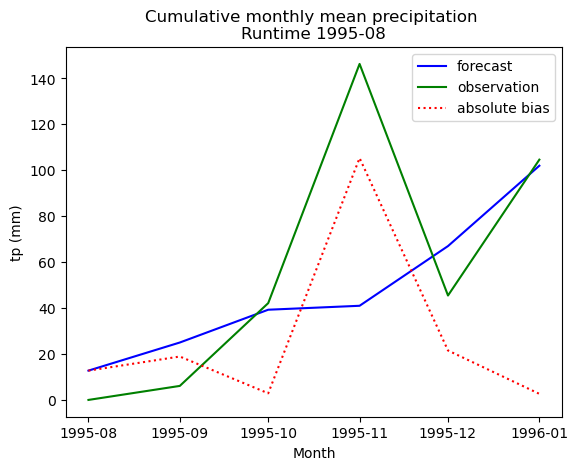

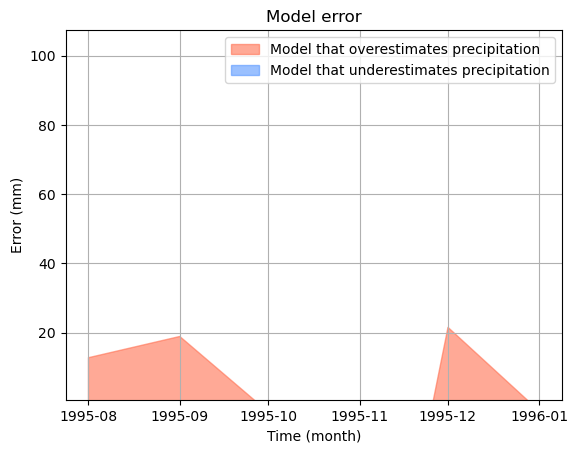

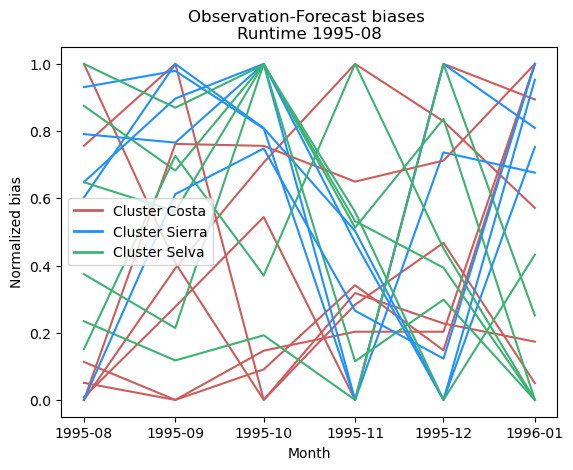

In [12]:
grid_method = 'nearest'
year = 1995
month = 8
par = 'tp'

# For the current runtime
print('Current runtime _____________________________________________________________ \n')

# Import the forecast data for this runtime
ds = get_c3s_data_downscaled(par,year,month)
time_min, time_max = pd.to_datetime(ds.time.min().values), pd.to_datetime(ds.time.max().values)

start_date = time_min.strftime('%Y-%m-01')
nb_days = ds.time.dt.days_in_month
end_date = (time_min + pd.DateOffset(months=5)).strftime(f'%Y-%m-{nb_days[-1].values}')
runtime = f"Runtime: {time_min:%Y-%m}, forecast until: {time_max:%Y-%m}."

print(runtime)
print('_____________________________________________________________________________ \n')


metrics = []

for index, row in filtered_stations.iterrows():
    
    ####### Forecast and observation
    
    # Station name and localisation
    station_name, cluster = row['name'], row['cluster']
    print(f'\nStation {station_name}, cluster {cluster} __________________________________________')
    lat_obs, lon_obs = row['lat'], row['lon']
    print(f'Latitude: {lat_obs}°, Longitude: {lon_obs}° \n')
    
    # Create the equivalent point from forecast
    ds_k = ds.sel(lon=lon_obs, lat=lat_obs, method=grid_method)
    print(f'Forecast \nLatitude: {ds_k.lat.values}°, Longitude: {ds_k.lon.values}° \n')
    
    # Select the period of the forecast data in the gsod data
    df = pd.read_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/GSOD/tp_month_1991_2020_{station_name}.csv')
    filtered_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    if (filtered_df.size == 0):
        print(f'No historical data for {year}-{month} for this station.')
    else: 
        
        ####### Metrics
        
        model = ds_k.tp
        reference = filtered_df.tp
        
        df = pd.DataFrame({'model': pd.Series(model.values), 'obs': pd.Series(reference.values)})
        
        #### Confusion table, rain and no rain
        thresholds = 5
        columns = ['obs', 'model']
        binned = wfstats.digitize(df, bins=thresholds, columns=columns)
        labels = [f"<{thresholds} mm", f"≥ {thresholds} mm"]
        digits = [0,1]
        
        cm_bin = plot_contingency(binned['obs'], binned['model'], digits, labels)
        tp, fp, fn, tn = cm_bin.ravel()
        stats = wfcontingency.ConfusionMatrixStatistics(tp, fp, fn, tn)
        ACC = stats.ACC * 100
        print(f'Accuracy for the contingency table rain/no rain: {"{:.2f}".format(ACC)} %\n')
        
        #### Contingency table, rain levels
        thresholds = [5, 20, 40, 60, 80, 120, 200]
        columns = ['obs', 'model']
        binned = wfstats.digitize(df, bins=thresholds, columns=columns)
        labels = [f"<{thresholds[0]}"] + [f"{value}" for value in thresholds]
        digits = [0,1,2,3,4,5,6,7]
        
        cm_levels = plot_contingency(binned['obs'], binned['model'], digits, labels)
        stats_list = wfcontingency.generate_stats_list(df, obs_col='obs', pred_col='model', bins=thresholds)
        #fig, ax = wfscoring_graphs.plot_ROC(stats_list, bins=thresholds, figsize=(5,5))

        (bias, mae, rmse, pears, skill) = compute_metrics(model, reference)  
        
        eval_forecast = evaluate_forecast(reference, model)
        print(f'Evaluation of the model for each month: \n{eval_forecast}\n')

        metrics.append({'name': station_name, 'cluster': cluster, 'mae': mae, 'rmse': rmse, 'accuracy': ACC, 
                        'pearson corr': pears, 'skill score': skill, 'norm_bias': bias, 'evaluation': eval_forecast, 'contingency':cm_levels})
        
        ####### Plot

        # Plot the station and forecast data for the runtime defined previously, with absolute bias
        time = ds.time
        plot_station_data(time, model, reference)
        # Plot the error of the model
        plot_model_error(model, reference, time)


# Create the metrics dataframe
sorted_metrics = sorted(metrics, key=lambda x: abs(x['rmse']))
df_metrics = pd.DataFrame(sorted_metrics)
df_metrics.to_csv(f'/home/jovyan/data/share/heloise/ESA-WP11/Anomaly/metrics_downscaled/metrics_gsod_c3s_downscaled_{year}_{month}.csv')

# Plot the bias for all stations 
plot_bias(df_metrics)


### Scoring and results

In [13]:
# Calculate the means by cluster
columns_to_mean = ['mae', 'rmse','accuracy', 'pearson corr', 'skill score']
averages_by_cluster = df_metrics.groupby('cluster')[columns_to_mean].mean()
averages_by_cluster = averages_by_cluster.applymap(lambda x: round(x, 3))


df_metrics['evaluate'] = [[1 if 'good' in val else 0 for val in sublist] for sublist in df_metrics['evaluation']]
evaluate_mean_cluster = df_metrics.groupby('cluster')['evaluate'].apply(lambda x: np.mean(x.tolist(), axis=0))
good_values = [['{:.0f}%'.format(val*100) for val in sublist] for sublist in evaluate_mean_cluster]

averages_by_cluster['% of good forecast'] = [good_values[i] for i in range(len(averages_by_cluster))]
print(averages_by_cluster)
averages_by_cluster.to_csv(f'metrics_by_cluster_gsod_c3s_downscaled_{year}_{month}.csv')

            mae    rmse  accuracy  pearson corr  skill score  \
cluster                                                        
costa     5.849   8.704    83.333        -0.002      -15.181   
selva    48.407  59.284    97.222         0.625        0.330   
sierra   30.961  37.751    80.000         0.698       -1.398   

                       % of good forecast  
cluster                                    
costa    [71%, 100%, 100%, 71%, 71%, 57%]  
selva      [0%, 50%, 33%, 83%, 67%, 100%]  
sierra      [20%, 0%, 40%, 60%, 80%, 80%]  


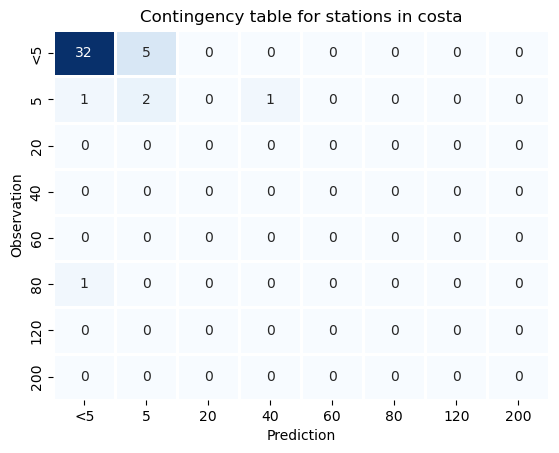

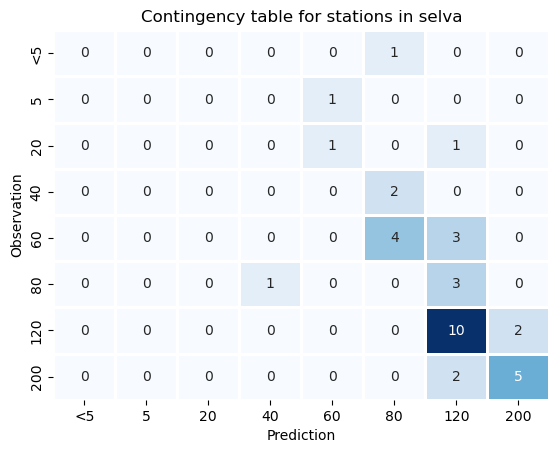

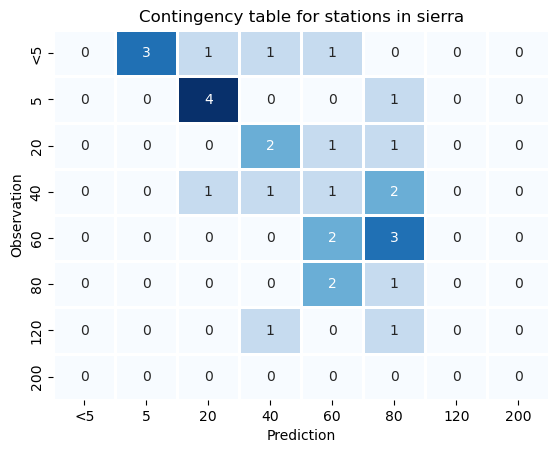

In [14]:
# Contingency table by cluster, sum of the stations in the cluster
cm_cluster = df_metrics.groupby('cluster')['contingency'].sum()
cluster_name = ['costa', 'selva', 'sierra']
for i in range (len(cm_cluster)):


    thresholds = [5, 20, 40, 60, 80, 120, 200]
    labels = [f"<{thresholds[0]}"] + [f"{value}" for value in thresholds]

    plt.figure()
    ax = plt.subplot()
    sns.heatmap(cm_cluster[i], annot=True, ax=ax, cbar=None, cmap="Blues", linewidths=1, linecolor="w")

    ax.set_xlabel('Prediction')
    ax.set_ylabel('Observation')
    ax.set_title(f'Contingency table for stations in {cluster_name[i]}')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

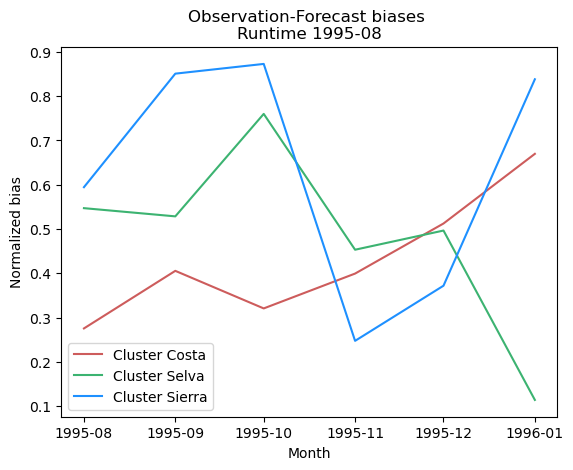

In [15]:
# Mean bias by cluster for the period of the runtime
all_bias = df_metrics.groupby('cluster')['norm_bias'].apply(lambda x: np.mean(x.tolist(), axis=0))

plt.plot(time, all_bias[0], color='indianred', label='Cluster Costa')
plt.plot(time, all_bias[1], color='mediumseagreen', label='Cluster Selva')
plt.plot(time, all_bias[2], color='dodgerblue', label='Cluster Sierra')

plt.legend()
plt.xlabel('Month')
plt.ylabel('Normalized bias')
plt.title(f'Observation-Forecast biases \nRuntime {time_min:%Y-%m}')
plt.show()